In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [67]:
data = pd.read_csv("./normalized_data.csv")

In [68]:
data

,timer,player1_id,player1_health,player1_is_jumping,player1_is_crouching,player1_is_player_in_move,player2_id,player2_health,player2_is_jumping,player2_is_crouching,player2_is_player_in_move,x_coord_diff,y_coord_diff,health 1,health 2,buttons_1
0,0.000000,0.0,0.000000,0,0,0,0.0,0.000000,0,0,0,1.000000,0.427273,0.000000,0.000000,0
1,0.000000,0.0,0.000000,0,0,0,0.0,0.000000,0,0,0,1.000000,0.427273,0.000000,0.000000,0
2,0.686275,1.0,0.000000,0,0,0,1.0,0.000000,0,0,0,0.661333,0.427273,0.000000,0.000000,0
3,0.000000,1.0,0.690196,0,0,0,1.0,0.690196,0,0,0,0.661333,0.427273,0.006902,0.006902,0
4,1.000000,1.0,0.690196,0,0,0,1.0,0.690196,0,0,0,0.389333,0.427273,0.006902,0.006902,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.366013,0.0,0.000000,0,0,0,1.0,0.000000,0,0,0,0.000000,0.427273,0.000000,0.000000,144
5056,0.366013,0.0,0.000000,0,0,0,1.0,0.000000,0,0,0,0.000000,0.427273,0.000000,0.000000,0
5057,0.366013,0.0,0.000000,0,0,0,1.0,0.000000,0,0,0,0.000000,0.427273,0.000000,0.000000,0
5058,0.366013,0.0,0.000000,0,0,0,1.0,0.000000,0,0,0,0.000000,0.427273,0.000000,0.000000,128


## Model

### Decision Tree

In [69]:
MeanAbsoluteError_DecisionTree = 0
MeanSquaredError_DecisionTree = 0
RSquared_DecisionTree = 0

train = data.sample(frac=0.8, random_state=200)
test = data.drop(train.index)

def DecisionTreeModel():
    global MeanAbsoluteError_DecisionTree
    global MeanSquaredError_DecisionTree
    global RSquared_DecisionTree
    
    # Preprocess the data to ensure all columns are numeric
    train_numeric = train.apply(pd.to_numeric, errors='coerce')
    train_numeric = train_numeric.dropna()  # Remove rows with NaN values
    
    test_numeric = test.apply(pd.to_numeric, errors='coerce')
    test_numeric = test_numeric.dropna()  # Remove rows with NaN values
    
    # MAKING DECISION TREE MODEL
    X_train = train_numeric.drop(['buttons_1'], axis=1)
    y_train = train_numeric['buttons_1']

    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # SAVING MODEL TO A FILE
    joblib.dump(model, 'decision_tree_model.pkl')

    # PREDICT Y(GAP) USING THE X_train
    X_test = test_numeric.drop(['buttons_1'], axis=1)
    y_test = test_numeric['buttons_1']
    y_pred = model.predict(X_test)

    # FINDING ERRORS FOR DECISION TREE
    MeanAbsoluteError_DecisionTree = mean_absolute_error(y_test, y_pred)
    MeanSquaredError_DecisionTree = mean_squared_error(y_test, y_pred)
    RSquared_DecisionTree = r2_score(y_test, y_pred)

    print("Mean Absolute Error:", MeanAbsoluteError_DecisionTree)
    print("Mean Squared Error:", MeanSquaredError_DecisionTree)
    print("R-squared:", RSquared_DecisionTree)

    return model


In [70]:
m = DecisionTreeModel()

Mean Absolute Error: 160.46172880243446
Mean Squared Error: 46496.4841025413
R-squared: -0.5239899788512243


In [72]:
d = {
    'timer':[0.771241],
    'player1_id':[1],
    'player1_health':[0.02745], 
    'player1_is_jumping':[0], 
    'player1_is_crouching':[0], 
    'player1_is_player_in_move':[1], 
    'player2_id':[1], 
    'player2_health':[0.47058], 
    'player2_is_jumping':[0],
    'player2_is_crouching':[1], 
    'player2_is_player_in_move':[0],        
    'x_coord_diff':[0.5366],
    'y_coord_diff':[0.4272],
    'health 1':[0.000274],
    'health 2':[0.004706]
}

x = pd.DataFrame(d)

y = int(m.predict(x)[0])
binary_str = format(int(bin(y)[2:]), '010')

print(y)
print(binary_str)

160
0010100000


### Neural Network

In [73]:
train = data.sample(frac=0.8, random_state=200)
test = data.drop(train.index)

train_x = torch.from_numpy(train[['player1_health', 'player1_is_jumping', 'player1_is_crouching', 'player1_is_player_in_move', 
                                  'player2_id', 'player2_health', 'player2_is_jumping', 'player2_is_crouching', 
                                  'player2_is_player_in_move','x_coord_diff', 'y_coord_diff']].values).float()
train_y = torch.from_numpy(train[['buttons_1']].values).float()

test_x = torch.from_numpy(test[['player1_health', 'player1_is_jumping', 'player1_is_crouching', 'player1_is_player_in_move', 
                                  'player2_id', 'player2_health', 'player2_is_jumping', 'player2_is_crouching', 
                                  'player2_is_player_in_move','x_coord_diff', 'y_coord_diff']].values).float()
test_y = torch.from_numpy(test[['buttons_1']].values).float()

In [74]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 =  nn.Linear(11, 144)
        self.a1 = nn.ReLU()
        self.layer2 = nn.Linear(144, 64)
        self.a2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.a1(x)
        x = self.layer2(x)
        x = self.a2(x)
        x = self.layer3(x)
        
        return x

Epoch: 0, Loss: -0.0
Epoch: 100, Loss: -0.0
Epoch: 200, Loss: -0.0
Epoch: 300, Loss: -0.0
Epoch: 400, Loss: -0.0


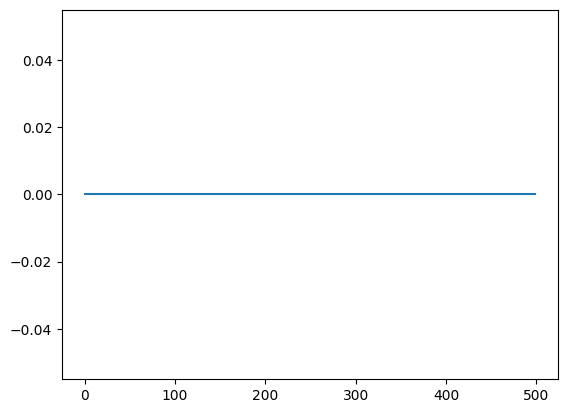

In [75]:
newt = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(newt.parameters(), lr=0.001)
losses = []
for epoch in range(500):
    optimizer.zero_grad()
    out = newt(train_x)
    loss = criterion(out, train_y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

plt.plot(losses)
plt.show()

In [76]:
# Predict the test data
out = newt(test_x)
_, predicted = torch.max(out.data, 1)
# print('Predicted: ', predicted)
# print('Actual: ', test_y.squeeze())

# Calculate the accuracy
correct = 0
total = len(predicted)
for i in range(total):
    if predicted[i] == test_y[i]:
        correct += 1

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 50 %


In [77]:
with torch.no_grad():
    outputs = newt(test_x)
    predicted = outputs.round().squeeze()
    accuracy = (predicted == test_y.squeeze()).sum().item() / len(test_y)
    print('Accuracy: {:.2f}%'.format(accuracy*100))

Accuracy: 50.00%
